## I'm Something of a Painter Myself

### Introduction
- In this project, I will be using CycleGan to convert photos to Monet painting style using the Kaggle "I'm Something of a Painter Myself" data
- The data format used will be TFRecords, as opposed to JPEG, which will require additional formatting
- As recommended in the Kaggle project overview, I will leverage guidance provided in [Amy Jang's](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial) notebook

### Imports
- Library Imports

In [89]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import glob
import numpy as np
import time
import shutil

from tensorflow.keras import layers
from PIL import Image

autotune = tf.data.experimental.AUTOTUNE

- Import Data

In [9]:
# data paths
path = './module5/kaggle_monet_data/gan-getting-started'

monet_tfrec = tf.io.gfile.glob(f'{path}/monet_tfrec/*')
photo_tfrec = tf.io.gfile.glob(f'{path}/photo_tfrec/*')

In [ ]:
# functions to format the imported TFRecord data; maintains a 256x256 with channels = 3 to match RGB
image_size = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1 # scale to [-1, 1]
    image = tf.reshape(image, [*image_size, 3])

    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])

    return image

# function to load the files and extract the images, with shuffle
def load_dataset(filenames, batch_size = 1, buffer_size = 2048):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls = autotune)
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)

    return dataset

In [12]:
# load the data
monet_df = load_dataset(monet_tfrec)
photo_df = load_dataset(photo_tfrec)

### EDA
- Plot Monet and Photo samples
    - As the plots below show, the Monet images are 'blurry' and contain fewer colors when compared to Photos

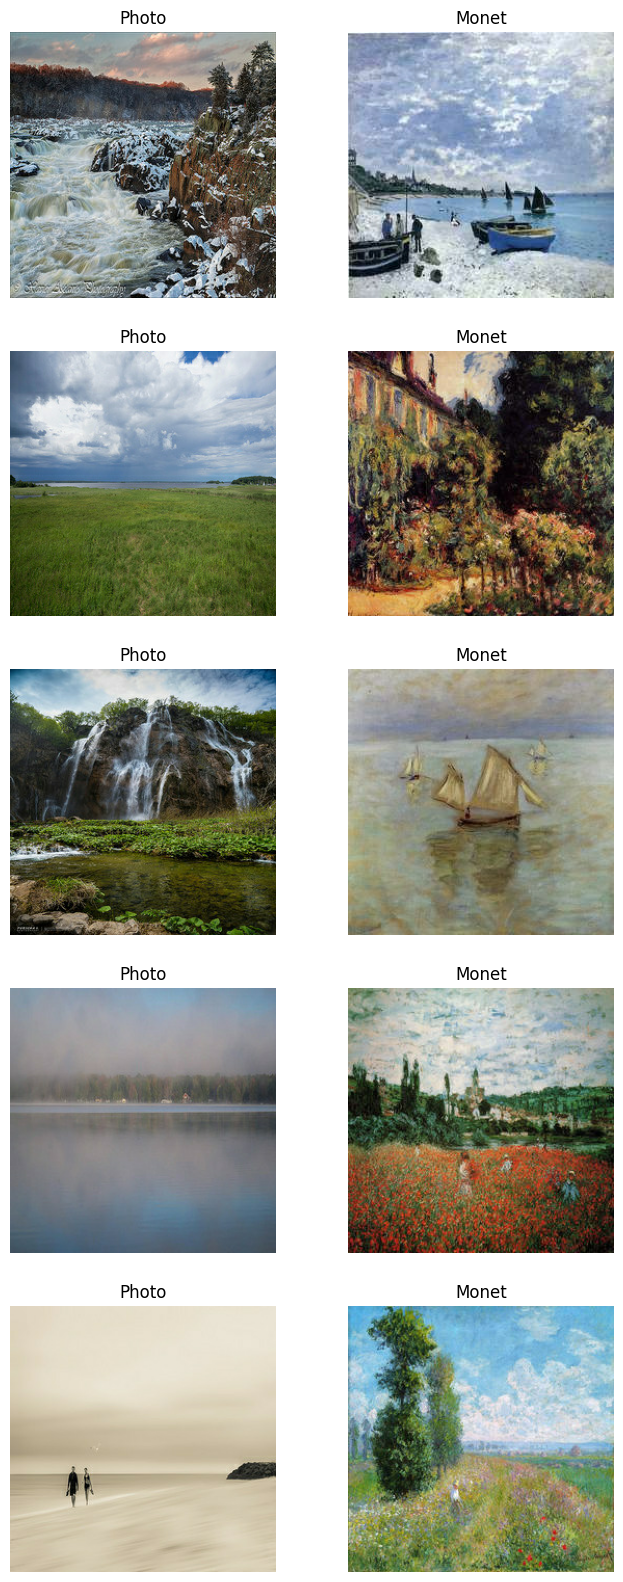

In [ ]:
# side-by-side plotting function - iterate through the available images
def plt_side_by_side(monet_df, photo_df, n_plots):
    photo_n = iter(photo_df)
    monet_n = iter(monet_df)

    plt.figure(figsize=(8, 4 * n_plots))
    for i in range(n_plots):
        photo = next(photo_n)[0]
        monet = next(monet_n)[0]
        photo = (photo + 1) / 2
        monet = (monet + 1) / 2

        plt.subplot(n_plots, 2, 2 * i + 1)
        plt.imshow(photo)
        plt.title('Photo')
        plt.axis('off')

        plt.subplot(n_plots, 2, 2 * i + 2)
        plt.imshow(monet)
        plt.title('Monet')
        plt.axis('off')        
    plt.show()

plt_side_by_side(monet_df, photo_df, 5) 

- Visualize differences in RGB distributions
    - As the plots show, the Monet RGB distribution is typically concentrated within a small range on the [0, 255] x-axis
    - By contrast, Photos are not as concentrated, highlighting how much more colors and color variation can be captured by photos  

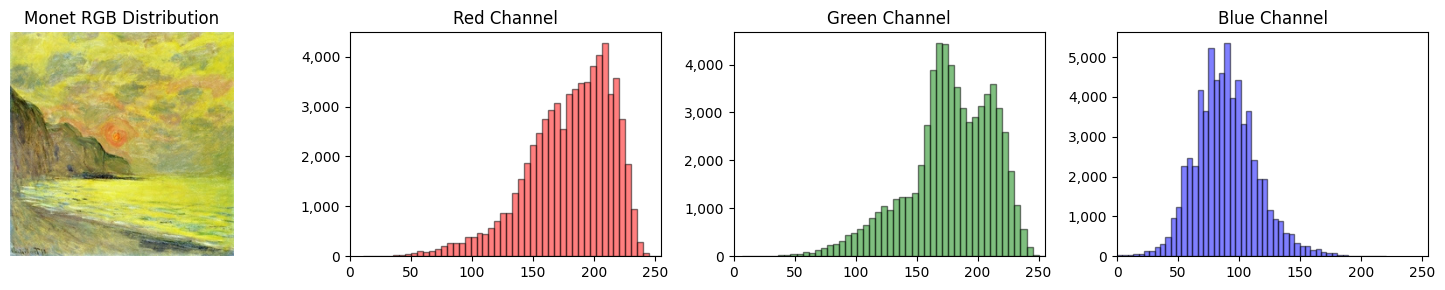

None

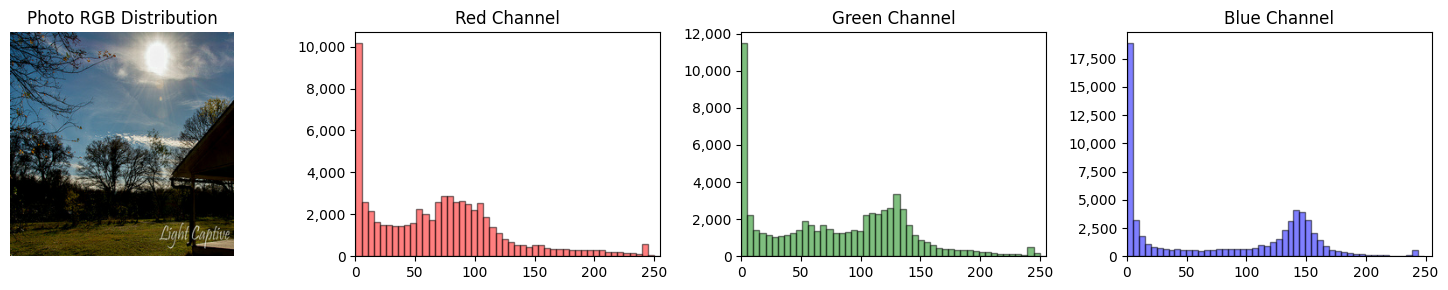

None

In [61]:
# function to plot RGB distribution for a Monet and Photo sample
def rgb_distribution(image, title):
    img = ((image[0] * 0.5 + 0.5) * 255).numpy().astype(np.uint8) # rescale to 255

    plt.figure(figsize=(15, 3))
    plt.subplot(1, 4, 1)
    plt.title(title)
    plt.imshow(img)
    plt.axis('off')

    colors = ['red', 'green', 'blue']
    for i, color in enumerate(colors):
        ax = plt.subplot(1, 4, i + 2)
        ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
        plt.title(f'{color.capitalize()} Channel')
        plt.hist(img[:,:,i].flatten(), bins=50, color=color, edgecolor='black', alpha=0.5)
        plt.xlim([0, 255])

    plt.tight_layout()
    plt.show()

display(rgb_distribution(next(iter(monet_df)), 'Monet RGB Distribution'))   
display(rgb_distribution(next(iter(photo_df)), 'Photo RGB Distribution'))

### GAN Modeling
- Model Architecture
Following Amy Jang's example, with some modifications, I will build a CycleGAN model that consists of:
    - two generators: photo -> monet **and** monet -> photo
        - The generator consists of downsampling(Encoding) part, ResNet block (residual blocks), and an upsampling (Decoding) part
        - Residual Block are used to learn residual functions and refine the images
    - two discriminators: is photo real or generated **and** is monet real or generated 
        - The common PatchGAN design is used to determine if images are real of fake
    - four loss functions:
        1. adversarial loss: loss function to determine if fake is authentic
        2. discriminator loss: determine fake from real
        3. cycle-consistency loss: retain original content for images translated back and forth (photo -> monet -> photo)
        4. identity loss: images is target style remain unchanged

- Generator - both generators leverage the same structure

In [62]:
def resnet_block(x, filters):
    y = layers.Conv2D(filters, (3, 3), padding='same')(x)
    y = layers.GroupNormalization(groups=1, axis=-1)(y)
    y = layers.Activation('relu')(y)
    y = layers.Conv2D(filters, (3, 3), padding='same')(y)
    y = layers.GroupNormalization(groups=1, axis=-1)(y)

    return layers.add([x, y])

# generator function
def build_generator(image_shape=(256, 256, 3), n_res_blocks=9):
    inputs = layers.Input(shape=image_shape)

    # Encoder
    x = layers.Conv2D(64, (7, 7), padding='same')(inputs)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(128, (3, 3), strides=2, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(256, (3, 3), strides=2, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.Activation('relu')(x)

    # ResNet Blocks
    for _ in range(n_res_blocks):
        x = resnet_block(x, 256)

    # Decoder
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(3, (7, 7), padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs, x)


- Discriminator - both discriminators leverage the same structure

In [64]:
# discriminator function
def build_discriminator(image_shape=(256, 256, 3)):
    inputs = layers.Input(shape=image_shape)

    x = layers.Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, (4, 4), strides=2, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, (4, 4), strides=2, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(512, (4, 4), strides=1, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, (4, 4), strides=1, padding='same')(x)

    return tf.keras.Model(inputs, x)

- Loss functions

In [65]:
LAMBDA_CYCLE = 10.0
LAMBDA_ID = 5.0

# BCE for real vs. fake
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Adversarial Loss 
def generator_adversarial_loss(fake_output):
    return loss_obj(tf.ones_like(fake_output), fake_output)

# Discriminator Loss 
def discriminator_loss(real_output, fake_output):
    real_loss = loss_obj(tf.ones_like(real_output), real_output)
    fake_loss = loss_obj(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss) * 0.5

# Cycle-consistency Loss
def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA_CYCLE * loss

# Identity Loss
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA_ID * loss

# Optimizers 
generator_pm_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_mp_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_p_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_m_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

- Model Building
    - Create the structure for the model to cycle through the generators and discriminators

In [ ]:
# two generators
generator_pm = build_generator()  # Photo → Monet
generator_mp = build_generator()  # Monet → Photo

# two discriminators
discriminator_p = build_discriminator()  # Discriminates Photos
discriminator_m = build_discriminator()  # Discriminates Monet

- Define training step

In [67]:
@tf.function
def train_step(real_p, real_m):
    with tf.GradientTape(persistent=True) as tape:
        # --------------------------------
        # Generator_PM: Photo -> Monet
        # --------------------------------
        fake_m = generator_pm(real_p, training=True)
        cycled_p = generator_mp(fake_m, training=True)

        # --------------------------------
        # Generator_MP: Monet -> Photo
        # --------------------------------
        fake_p = generator_mp(real_m, training=True)
        cycled_m = generator_pm(fake_p, training=True)

        # --------------------------------
        # Identity Mapping
        # --------------------------------
        same_p = generator_mp(real_p, training=True)
        same_m = generator_pm(real_m, training=True)

        # --------------------------------
        # Discriminator Outputs
        # --------------------------------
        disc_real_p = discriminator_p(real_p, training=True)
        disc_real_m = discriminator_m(real_m, training=True)
        disc_fake_p = discriminator_p(fake_p, training=True)
        disc_fake_m = discriminator_m(fake_m, training=True)

        # --------------------------------
        # Generator Losses
        # --------------------------------
        gen_pm_loss = generator_adversarial_loss(disc_fake_m)
        gen_mp_loss = generator_adversarial_loss(disc_fake_p)

        total_cycle_loss = calc_cycle_loss(real_p, cycled_p) + calc_cycle_loss(real_m, cycled_m)

        total_gen_pm_loss = gen_pm_loss + total_cycle_loss + identity_loss(real_m, same_m)
        total_gen_mp_loss = gen_mp_loss + total_cycle_loss + identity_loss(real_p, same_p)

        # --------------------------------
        # Discriminator Losses
        # --------------------------------
        disc_p_loss = discriminator_loss(disc_real_p, disc_fake_p)
        disc_m_loss = discriminator_loss(disc_real_m, disc_fake_m)

    # --------------------------------
    # Calculate and Apply Gradients
    # --------------------------------
    generator_pm_gradients = tape.gradient(total_gen_pm_loss, generator_pm.trainable_variables)
    generator_mp_gradients = tape.gradient(total_gen_mp_loss, generator_mp.trainable_variables)

    discriminator_p_gradients = tape.gradient(disc_p_loss, discriminator_p.trainable_variables)
    discriminator_m_gradients = tape.gradient(disc_m_loss, discriminator_m.trainable_variables)

    generator_pm_optimizer.apply_gradients(zip(generator_pm_gradients, generator_pm.trainable_variables))
    generator_mp_optimizer.apply_gradients(zip(generator_mp_gradients, generator_mp.trainable_variables))

    discriminator_p_optimizer.apply_gradients(zip(discriminator_p_gradients, discriminator_p.trainable_variables))
    discriminator_m_optimizer.apply_gradients(zip(discriminator_m_gradients, discriminator_m.trainable_variables))

    return {
        'gen_pm_loss': total_gen_pm_loss,
        'gen_mp_loss': total_gen_mp_loss,
        'disc_p_loss': disc_p_loss,
        'disc_m_loss': disc_m_loss
    }

- Model Training

In [69]:
def train(dataset_P, dataset_M, epochs=1):
    history = {
        'gen_pm_loss': [],
        'gen_mp_loss': [],
        'disc_p_loss': [],
        'disc_m_loss': []
    }
    
    for epoch in range(epochs):
        start = time.time()
        print(f"Epoch {epoch+1}/{epochs}")
        
        gen_pm_losses = []
        gen_mp_losses = []
        disc_p_losses = []
        disc_m_losses = []
        
        for real_p, real_m in tf.data.Dataset.zip((dataset_P, dataset_M)):
            losses = train_step(real_p, real_m)
            gen_pm_losses.append(losses['gen_pm_loss'].numpy())
            gen_mp_losses.append(losses['gen_mp_loss'].numpy())
            disc_p_losses.append(losses['disc_p_loss'].numpy())
            disc_m_losses.append(losses['disc_m_loss'].numpy())
        
        # Average for the epoch
        history['gen_pm_loss'].append(np.mean(gen_pm_losses))
        history['gen_mp_loss'].append(np.mean(gen_mp_losses))
        history['disc_p_loss'].append(np.mean(disc_p_losses))
        history['disc_m_loss'].append(np.mean(disc_m_losses))
        
        print(f"Time for epoch {epoch+1}: {time.time() - start:.2f} sec")
        print(f"Gen_PM Loss: {history['gen_pm_loss'][-1]:.4f} | Gen_MP Loss: {history['gen_mp_loss'][-1]:.4f}")
        print(f"Disc_P Loss: {history['disc_p_loss'][-1]:.4f} | Disc_M Loss: {history['disc_m_loss'][-1]:.4f}\n")
    
    return history

In [70]:
# execute model
history = train(photo_df, monet_df, epochs=10)

Epoch 1/10


2025-11-12 18:00:49.306288: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 1: 676.21 sec
Gen_PM Loss: 9.6714 | Gen_MP Loss: 9.2545
Disc_P Loss: 0.6905 | Disc_M Loss: 0.6082

Epoch 2/10


2025-11-12 18:16:04.910031: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 2: 915.60 sec
Gen_PM Loss: 7.3382 | Gen_MP Loss: 7.3511
Disc_P Loss: 0.6475 | Disc_M Loss: 0.6142

Epoch 3/10
Time for epoch 3: 696.51 sec
Gen_PM Loss: 7.1341 | Gen_MP Loss: 7.3146
Disc_P Loss: 0.6231 | Disc_M Loss: 0.6037

Epoch 4/10


2025-11-12 18:44:19.175874: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 4: 997.76 sec
Gen_PM Loss: 7.0843 | Gen_MP Loss: 6.9985
Disc_P Loss: 0.6127 | Disc_M Loss: 0.5261

Epoch 5/10
Time for epoch 5: 694.35 sec
Gen_PM Loss: 6.7169 | Gen_MP Loss: 6.3880
Disc_P Loss: 0.6351 | Disc_M Loss: 0.5276

Epoch 6/10
Time for epoch 6: 699.57 sec
Gen_PM Loss: 6.0804 | Gen_MP Loss: 5.6143
Disc_P Loss: 0.6228 | Disc_M Loss: 0.4654

Epoch 7/10
Time for epoch 7: 700.73 sec
Gen_PM Loss: 5.8584 | Gen_MP Loss: 5.6583
Disc_P Loss: 0.6065 | Disc_M Loss: 0.5468

Epoch 8/10


2025-11-12 19:40:54.919539: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 8: 1301.10 sec
Gen_PM Loss: 5.2767 | Gen_MP Loss: 5.3004
Disc_P Loss: 0.5797 | Disc_M Loss: 0.6081

Epoch 9/10
Time for epoch 9: 686.19 sec
Gen_PM Loss: 5.1771 | Gen_MP Loss: 5.2891
Disc_P Loss: 0.5913 | Disc_M Loss: 0.6152

Epoch 10/10
Time for epoch 10: 702.66 sec
Gen_PM Loss: 5.0540 | Gen_MP Loss: 4.9444
Disc_P Loss: 0.6178 | Disc_M Loss: 0.5865



- Model Evaluation
    - Plot the losses across epochs for:
        1. Photo -> Monet generator
        2. Monet -> Photo generator
        3. Photo discriminator
        4. Monet discriminator
    - As the plots below show:
        - The generator losses gradually decrease from the first epoch through the tenth epoch
            - While the losses for both generator decrease, there is room for improvement given that the losses have not plateaued and remain above 5
        - The discriminator losses are relatively small and remain within a narrow range throughout all epochs: between 0.5 and 0.7
            - This suggests that the discriminator learn to distinguish fake vs. real relatively quickly

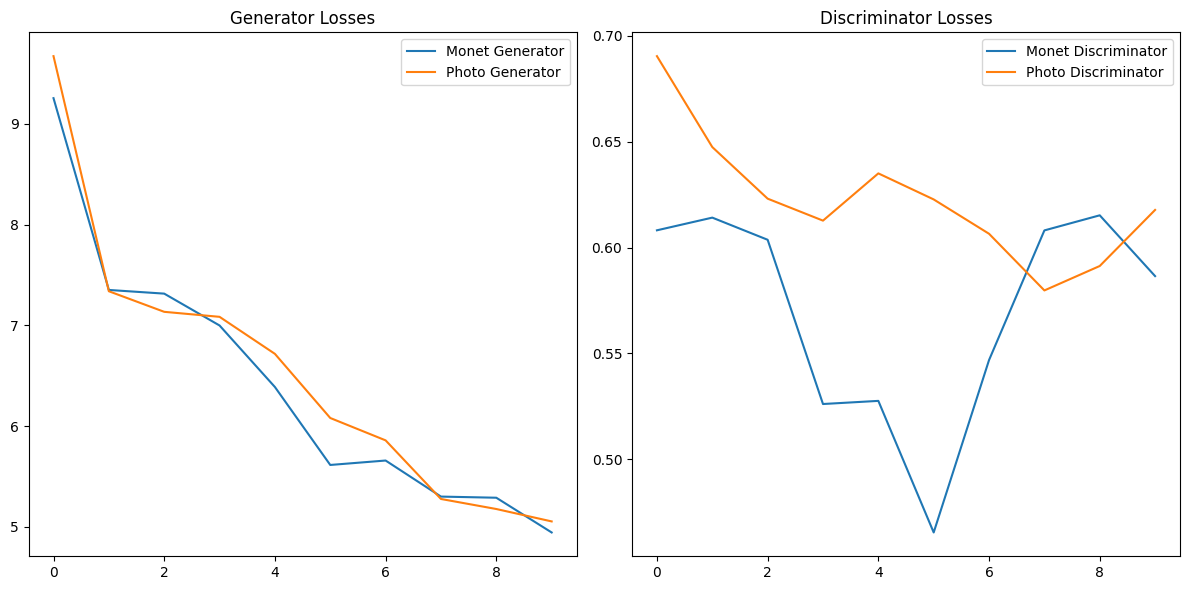

In [75]:
# generator losses over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['gen_mp_loss'], label='Monet Generator')
plt.plot(history['gen_pm_loss'], label='Photo Generator')
plt.title('Generator Losses')
plt.legend()

# discriminator losses over epochs
plt.subplot(1, 2, 2)
plt.plot(history['disc_m_loss'], label='Monet Discriminator')
plt.plot(history['disc_p_loss'], label='Photo Discriminator')
plt.title('Discriminator Losses')
plt.legend()

plt.tight_layout()
plt.show()

- Photo -> Monet Conversion
    - As the plots below show, the Monet-style converted photos have acquired the blurriness typically associated with Monet but we can still make out the original photo in them

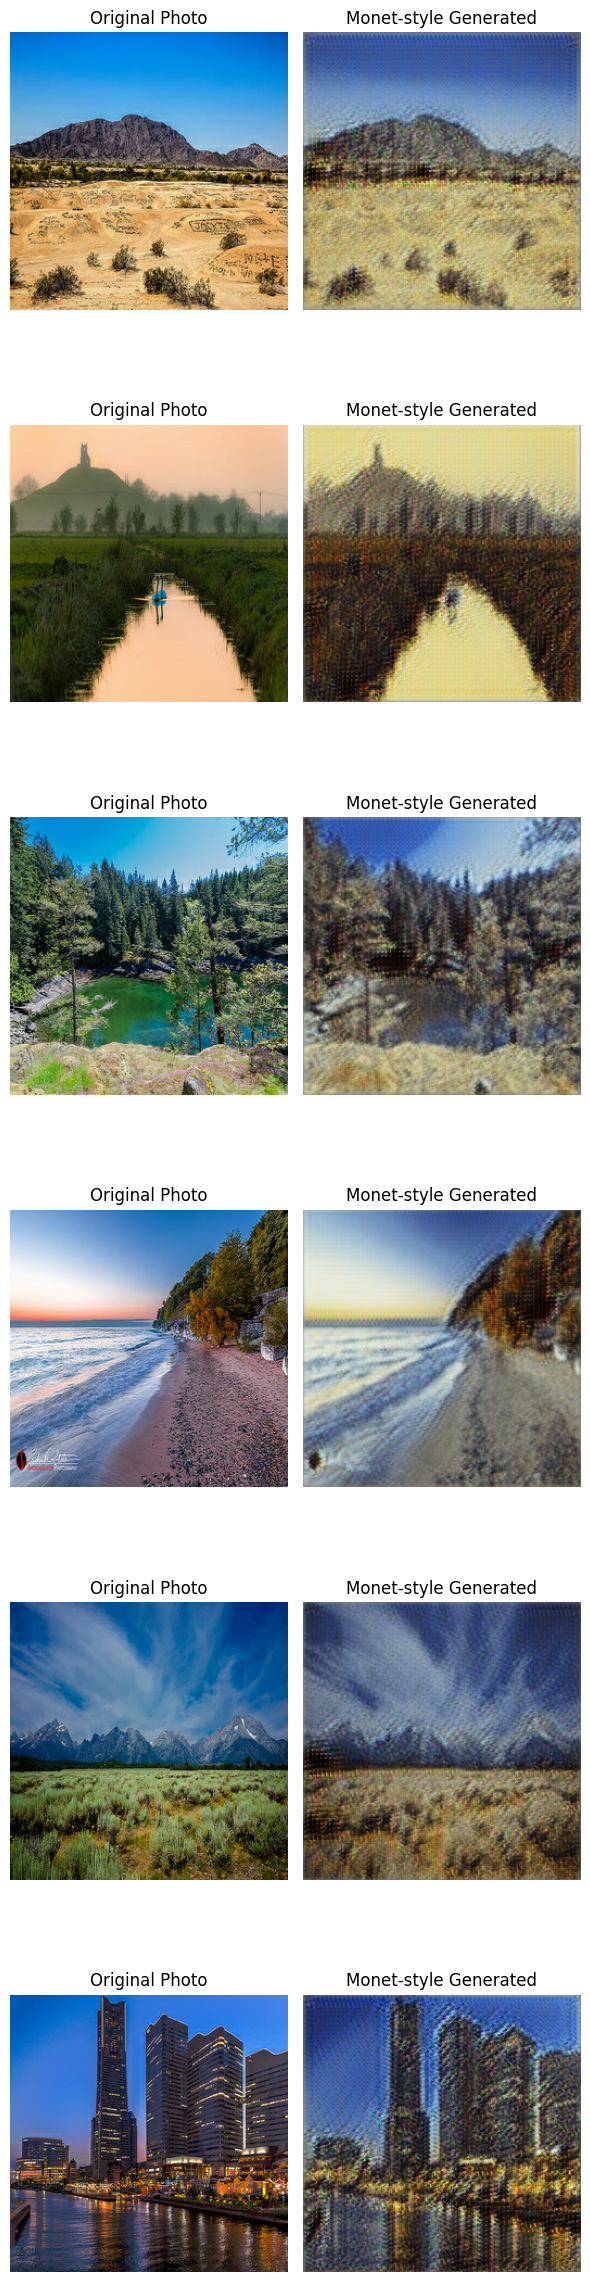

In [84]:
# function to plot photos converted to Monet-style
def display_grid(model, ds, n_plot):
    _, axes = plt.subplots(n_plot, 2, figsize=(6, 4 * n_plot))
    
    for i, img in enumerate(ds.take(n_plot)):
        prediction = model(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
        
        axes[i, 0].imshow(img)
        axes[i, 1].imshow(prediction)
        axes[i, 0].set_title("Original Photo")
        axes[i, 1].set_title("Monet-style Generated")
        axes[i, 0].axis("off")
        axes[i, 1].axis("off")
    
    plt.tight_layout()
    plt.show()

display_grid(generator_pm, photo_df, 6)

#### Kaggle Submission
- Generate the Photo -> Monet images for submission
- Convert generated image to JPEG format and creat zip file

In [88]:
# generate Monet-style images
i = 1

for img in photo_df:
    if i % 500 == 0:
        print(f'Images Processed: {i}')

    pred = generator_pm(img, training=False)[0].numpy()
    pred = (pred * 127.5 + 127.5).astype(np.uint8)
    im = Image.fromarray(pred)
    im.save(f'{path}/kaggle_submission/{str(i)}.jpg')
    i += 1

Images Processed: 500
Images Processed: 1000
Images Processed: 1500
Images Processed: 2000
Images Processed: 2500
Images Processed: 3000
Images Processed: 3500
Images Processed: 4000
Images Processed: 4500
Images Processed: 5000
Images Processed: 5500
Images Processed: 6000
Images Processed: 6500
Images Processed: 7000


In [92]:
# create zip file for submission
shutil.make_archive(f'{path}/images', 'zip', f'{path}/kaggle_submission')

'/Users/manuelportillo/coursera/ms_ai/csca_5624_intro_deep_learning/module5/kaggle_monet_data/gan-getting-started/images.zip'

- Score for images submission

<img src="monet_images_score.png" alt="drawing" width="1200"/>

### Conclusion
- I was able to follow guidance provided in Amy Jang's notebook to implement a CycleGAN model
- The structure for the model used is as follows:
    1. Two generators
        - ResNet Block between Encoder and Decoder sections
    2. Two discriminators
    3. Four loss functions
- Ten epochs were used for training. Unfortunately, it took an average of 13 minutes for each epoch to complete
- While the results obtained successfully demonstrate the Photo -> Monet conversions, the following areas can be improved:
    1. The generator losses have not plateaued or being minimized
        - I can test additional epochs or test different approaches that would require less time
    2. Apply hyperparameter tuning. For example, a learning rate scheduler or dropout options can be added

Overall, the exercise helped me better understand the GAN modeling framework and its applications. In the future, I will test building additional models to test on data with other different painting styles. 